# Disentangled RNNs for Mouse Switching Dataset
The dataset below is from [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/7E0NM5). Each row corresponds to a trial, and the columns correspond to the trial number, block position, target direction, choice direction, and reward outcome, as well as the session and mouse identifiers and task conditions.

| Trial | blockTrial | Decision | Switch | Reward | Condition | Target | blockLength | Session | Mouse |
|-------|------------|----------|--------|--------|-----------|--------|-------------|---------|-------|
| 11.0  | 11.0       | 1.0      | 0.0    | 1.0    | 90-10     | 1.0    | 58.0        | m1_77   | m1    |
| 12.0  | 12.0       | 1.0      | 0.0    | 1.0    | 90-10     | 1.0    | 58.0        | m1_77   | m1    |
| 13.0  | 13.0       | 1.0      | 0.0    | 1.0    | 90-10     | 1.0    | 58.0        | m1_77   | m1    |

In [4]:
from disentangled_rnns.library import rnn_utils
from disentangled_rnns.library import disrnn
from disentangled_rnns import switch_utils
import optax
from tqdm.auto import tqdm
from datetime import datetime
import os
from matplotlib import pyplot as plt
import numpy as np


addr = "/Users/michaelcondon/workspaces/pbm_group2/2ABT_behavior_models/bandit_data.csv"
# list of tuples containing datasets for train, val, test.
ds_list = switch_utils.get_dataset(addr, batch_size=30, tr_prop=0.5, va_prop=0.5, te_prop=0.0)

In [5]:
update_mlp_shape = (5,5,5)
choice_mlp_shape = (2,2)
latent_size = 5

def make_network():
  return disrnn.HkDisRNN(update_mlp_shape=update_mlp_shape,
                        choice_mlp_shape=choice_mlp_shape,
                        latent_size=latent_size,
                        obs_size=2, target_size=2)

learning_rate = 1e-3
opt = optax.adam(learning_rate)

In [6]:
"""
Iterate through the mice, and through the beta values, saving the trained
params and loss for each in a json to disk.
"""
betas = [1e-3, 3e-3, 1e-2, 3e-2]
n_steps = 5e4

n_calls = len(ds_list) * len(betas)
dt = datetime.now().strftime("%Y-%m-%d_%H-%M")
print(f"start time: {dt}")
with tqdm(total=n_calls, desc='Overall Progress', position=1) as outer_bar:
  for m_i, dataset_tr, dataset_va, dataset_te in ds_list:
    # Train additional steps
    for beta_j in betas:
      outer_bar.set_postfix(mouse=f"{m_i}", beta=f"{beta_j:.0e}")
      params, opt_state, losses = rnn_utils.train_network(
      make_network,
          dataset_tr,
          dataset_va,
          ltype_tr="penalized_categorical",
          opt = optax.adam(learning_rate),
          penalty_scale = beta_j,
          n_steps=n_steps,
          do_plot = False)
      switch_utils.model_saver(params, m_i, beta_j, dt=dt, loss=losses)
      outer_bar.update(1)


start time: 2025-04-03_23-13


Overall Progress:   0%|          | 0/24 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Analysis
From here on, you can load models from disk for each mouse as trained above.

Text(0.5, 1.0, 'Loss over Training')

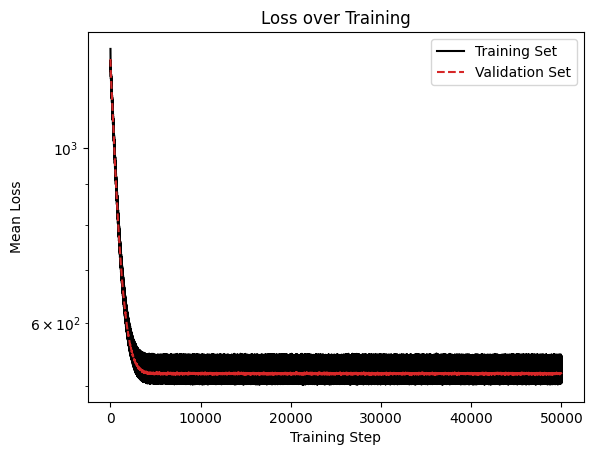

In [29]:

directory = "/Users/michaelcondon/workspaces/pbm_group2/disentangled_rnns/models/"

# choose mouse, beta and run time
mouse = "m1"
beta = 0.03
cv = 0
dt = "2025-04-03_23-13"


params_file = os.path.join(directory, f"params_{mouse}_{beta:.0e}_0_{dt}.json")
loss_file = os.path.join(directory, f"loss_{mouse}_{beta:.0e}_0_{dt}.json")

params, loss = switch_utils.model_loader(params_file=params_file, loss_file=loss_file)
training_loss = loss['training_loss']
validation_loss = loss['validation_loss']

plt.figure()
plt.semilogy(training_loss, color='black')
plt.semilogy(np.linspace(0, len(training_loss), len(validation_loss)), validation_loss, color='tab:red', linestyle='dashed')
plt.xlabel('Training Step')
plt.ylabel('Mean Loss')
plt.legend(('Training Set', 'Validation Set'))
plt.title('Loss over Training')

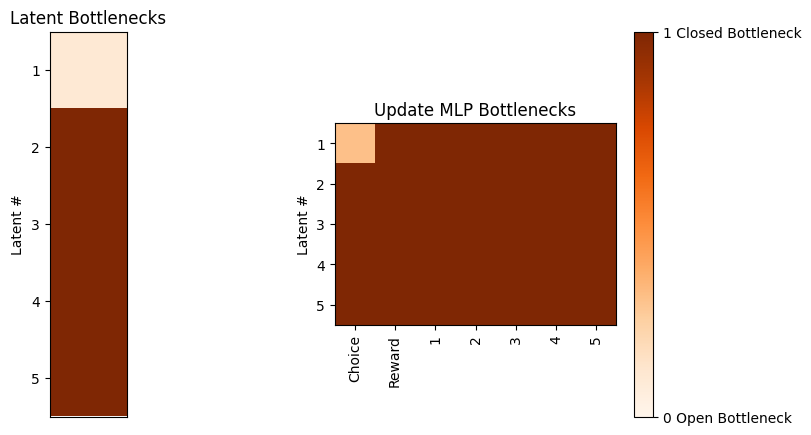

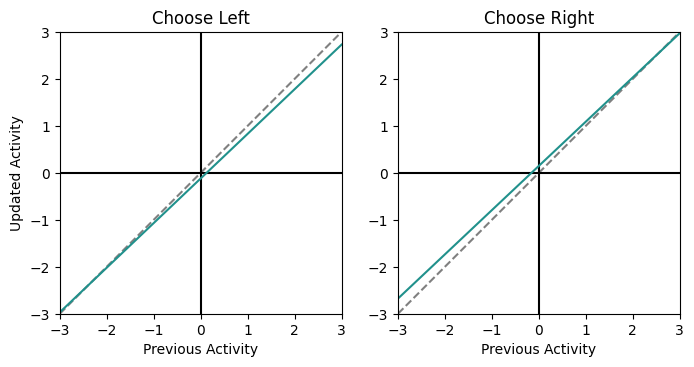

In [30]:
# Eval mode runs the network with no noise
def make_network_eval():
  return disrnn.HkDisRNN(update_mlp_shape=update_mlp_shape,
                        choice_mlp_shape=choice_mlp_shape,
                        latent_size=latent_size,
                        obs_size=2, target_size=2,
                        eval_mode=True)


disrnn.plot_bottlenecks(params, sort_latents=True)
plt.show()
disrnn.plot_update_rules(params, make_network_eval)
plt.show()

## Switching Analysis
Here I will check how the RNN models from above behave from a switching perspective. This is based on the comparisons from the paper:

    Beron, C. C., Neufeld, S. Q., Linderman, S. W., & Sabatini, B. L. (2022). Mice exhibit stochastic and efficient action switching during probabilistic decision making. Proceedings of the National Academy of Sciences, 119(15), e2113961119. https://doi.org/10.1073/pnas.2113961119


In [18]:
"""
Iterate through each session of each dataset.
"""
import itertools
import disentangled_rnns.switch_utils as switch_utils
import numpy as np
import matplotlib.pyplot as plt

addr = "/Users/michaelcondon/workspaces/pbm_group2/2ABT_behavior_models/bandit_data.csv"
# dataset with no division into training set etc
full_ds = switch_utils.get_dataset(addr, tr_prop=1.0, condition='80-20')
chars = 'lrLR'
h_len = 3
ds_2 = full_ds[1][1]._xs
seq_dict = {''.join(seq): [0,0] for seq in itertools.product(chars, repeat=3)}



dss = [full_ds[i][1]._xs for i in range(len(full_ds))]

for elem in dss:
  ds_2 = elem
  for k in range(np.shape(ds_2)[1]):
    session = ds_2[:,k]
    for i in range(h_len, len(session)):
      if session[i, 0] == -1:
        continue
      key = ''.join([chars[int(session[j, 0]+2*session[j, 1])] for j in range(i-h_len, i)])
      if session[i, 0] != session[i-1, 0]:
        seq_dict[key][0] += 1
      if session[i, 0] == session[i-1, 0]:
        seq_dict[key][1] += 1

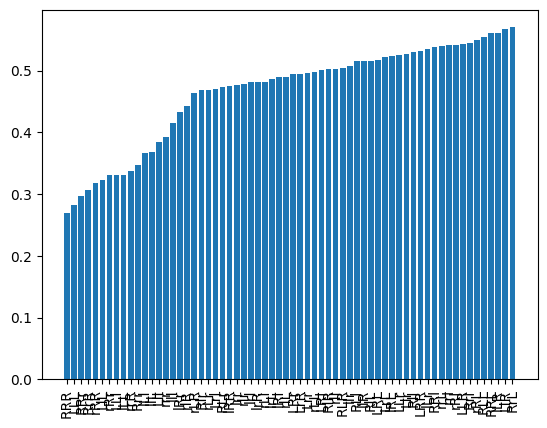

In [20]:
p_dict = {key: val[0]/(val[0]+val[1]) for key, val in seq_dict.items()}

sorted_items = sorted(p_dict.items(), key=lambda item: item[1])
sorted_labels = [item[0] for item in sorted_items]
sorted_heights = [item[1] for item in sorted_items]
total_height = sum(sorted_heights)
norm_height = [h / total_height for h in sorted_heights]

plt.bar(sorted_labels, sorted_heights)
plt.xticks(rotation=90)
plt.show()

In [21]:
eq_chars = 'aAbB'
eqs = list(itertools.product(eq_chars, repeat=h_len))[:len(eq_chars)**h_len//2]
eq_dict = {''.join(seq): 0 for seq in eqs}
for seq in eq_dict:
  tran1 = seq.translate(str.maketrans('abAB', 'lrLR'))
  tran2 = seq.translate(str.maketrans('abAB', 'rlRL'))
  eq_dict[seq] = (p_dict[tran1] + p_dict[tran2]) / 2

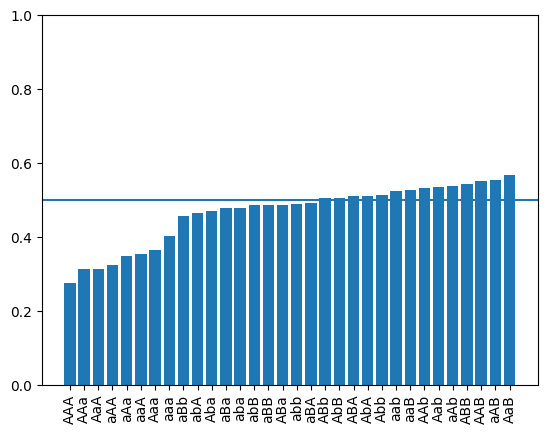

In [22]:
sorted_items = sorted(eq_dict.items(), key=lambda item: item[1])
sorted_labels = [item[0] for item in sorted_items]
sorted_heights = [item[1] for item in sorted_items]
total_height = sum(sorted_heights)
norm_height = [h / total_height for h in sorted_heights]

plt.bar(sorted_labels, sorted_heights)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.axhline(0.5)
plt.show()

In [26]:
import seaborn as sns

sns.set(style='ticks', font_scale=1.7, rc={'axes.labelsize':20, 'axes.titlesize':20})
sns.set_palette('deep')


fig, ax = plt.subplots(figsize=(14,4.2))

sns.barplot(x=sorted_labels, y=sorted_heights, color='k', alpha=0.5, ax=ax, edgecolor='gray')
ax.errorbar(x=sorted_labels, y=sorted_heights, yerr=sorted_heights+'_err', fmt=' ', color='k', label=None)

ax.set(xlim=(-1,len(sorted_heights)), ylim=(0,1), ylabel='P(switch)')
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()